### Exploratory Data Analysis (EDA) for Lok Sabha Debate Corpus

This notebook performs exploratory analysis on raw Lok Sabha debate text
(2023–2025 subset) to:

1. Estimate corpus size and speech density
2. Estimate candidate entity frequencies (Bills, Acts, Schemes, Locations)
3. Identify dominant lexical patterns
4. Validate feasibility of proposed NER label schema
5. Inform segmentation and regex design

We use only raw extracted text files. These are crucial to ensuring that we have the data for answering the research questions. 

In [2]:
import os
import re
import glob
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

RAW_DIR = "data/raw_text"

In [3]:
def extract_date_from_filename(filename):
    match = re.search(r'(\d{2}-\d{2}-\d{4})', filename)
    return match.group(1) if match else None

files = sorted(glob.glob(os.path.join(RAW_DIR, "*.txt")))

file_info = []
for f in files:
    date = extract_date_from_filename(f)
    file_info.append((f, date))

df_files = pd.DataFrame(file_info, columns=["filepath", "date"])
df_files["date"] = pd.to_datetime(df_files["date"], format="%d-%m-%Y", errors="coerce")

df_files = df_files.sort_values("date", ascending=False)

subset_files = df_files.head(30)["filepath"].tolist()

len(subset_files)


30

#### Corpus Size Overview

This gives us a sense of:

- Data volume
- Whether fine-tuning is feasible
- Expected annotation workload

This is prior to pruning out irrelevant portions on laying down legislative papers and their contents, interruptions, other formatting words. We will have to assess the word count that we will be manually annotating/ performing rule-based annotation on.

In [4]:
total_chars = 0
total_words = 0

for filepath in subset_files:
    with open(filepath, "r", encoding="utf-8") as f:
        text = f.read()
        total_chars += len(text)
        total_words += len(text.split())

print("Number of PDFs:", len(subset_files))
print("Total characters:", total_chars)
print("Total words:", total_words)


Number of PDFs: 30
Total characters: 3777149
Total words: 616467


In [7]:
import nltk
nltk.download('punkt')

from nltk.tokenize import sent_tokenize

total_sentences = 0

for filepath in subset_files:
    with open(filepath, "r", encoding="utf-8") as f:
        text = f.read()
        sentences = sent_tokenize(text)
        total_sentences += len(sentences)

print("Estimated total sentences:", total_sentences)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91887\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\91887/nltk_data'
    - 'c:\\Users\\91887\\Documents\\NER\\.venv\\nltk_data'
    - 'c:\\Users\\91887\\Documents\\NER\\.venv\\share\\nltk_data'
    - 'c:\\Users\\91887\\Documents\\NER\\.venv\\lib\\nltk_data'
    - 'C:\\Users\\91887\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


#### Candidate Legislative Entity Frequency

We check whether each entity type appears at least 50–100 times.

If an entity type is too sparse (<50 mentions),
it may not be suitable for fine-tuning.

In [8]:
bill_pattern = r'\b[A-Z][A-Za-z\s\-()]+ Bill, \d{4}'
act_pattern = r'\b[A-Z][A-Za-z\s\-()]+ Act, \d{4}'
scheme_pattern = r'\b[A-Z][A-Za-z\s\-()]+ Scheme\b'
rule_pattern = r'\bRule \d+\b'

bill_count = 0
act_count = 0
scheme_count = 0
rule_count = 0

for filepath in subset_files:
    with open(filepath, "r", encoding="utf-8") as f:
        text = f.read()
        bill_count += len(re.findall(bill_pattern, text))
        act_count += len(re.findall(act_pattern, text))
        scheme_count += len(re.findall(scheme_pattern, text))
        rule_count += len(re.findall(rule_pattern, text))

print("Bill mentions:", bill_count)
print("Act mentions:", act_count)
print("Scheme mentions:", scheme_count)
print("Rule mentions:", rule_count)


Bill mentions: 168
Act mentions: 304
Scheme mentions: 149
Rule mentions: 95


In [9]:
ministry_pattern = r'Ministry of [A-Za-z\s&]+'

ministry_count = 0

for filepath in subset_files:
    with open(filepath, "r", encoding="utf-8") as f:
        text = f.read()
        ministry_count += len(re.findall(ministry_pattern, text))

print("Ministry mentions:", ministry_count)


Ministry mentions: 454


In [10]:
state_keywords = [
    "Maharashtra", "Bihar", "Delhi", "Tamil Nadu",
    "Uttar Pradesh", "Rajasthan", "Odisha",
    "Gujarat", "West Bengal", "Karnataka"
]

state_counter = Counter()

for filepath in subset_files:
    with open(filepath, "r", encoding="utf-8") as f:
        text = f.read()
        for state in state_keywords:
            state_counter[state] += text.count(state)

state_counter


Counter({'Delhi': 418,
         'Bihar': 333,
         'Tamil Nadu': 223,
         'Maharashtra': 194,
         'Uttar Pradesh': 146,
         'Rajasthan': 134,
         'Odisha': 133,
         'Gujarat': 80,
         'Karnataka': 74,
         'West Bengal': 42})

In [11]:
speaker_pattern = r'\bSHRI\b|\bSHRIMATI\b|\bDR\.\b'

speaker_count = 0

for filepath in subset_files:
    with open(filepath, "r", encoding="utf-8") as f:
        text = f.read()
        speaker_count += len(re.findall(speaker_pattern, text))

print("Estimated speaker mentions:", speaker_count)


Estimated speaker mentions: 1635


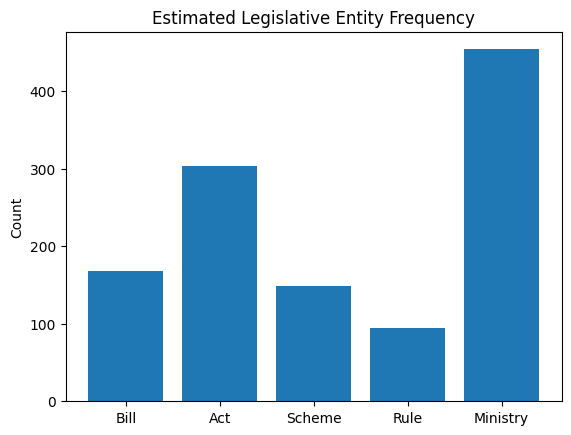

In [13]:
entity_counts = {
    "Bill": bill_count,
    "Act": act_count,
    "Scheme": scheme_count,
    "Rule": rule_count,
    "Ministry": ministry_count
}

plt.bar(entity_counts.keys(), entity_counts.values())
plt.title("Estimated Legislative Entity Frequency")
plt.ylabel("Count")
plt.show()


### Preliminary Observations

1. Are Bills frequent enough for supervised learning?
2. Are Acts frequent enough?
3. Are Schemes frequent enough?
4. Should Rule be included or excluded?
5. Is Ministry too frequent and too noisy?
6. Is speaker density sufficient for RQ1?

Based on these observations, we will:

- Finalize entity schema
- Design gazetteer lists
- Define regex refinement
- Decide on fine-tuning feasibility
